<a href="https://colab.research.google.com/github/ankit-rathi/Tradevesting/blob/main/myStocks_Portfolio_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
import os

# Install es_MX
!/usr/share/locales/install-language-pack en_IN
!dpkg-reconfigure locales

# Restart Python process to pick up the new locales
os.kill(os.getpid(), 9)
'''

'\nimport os\n\n# Install es_MX\n!/usr/share/locales/install-language-pack en_IN\n!dpkg-reconfigure locales\n\n# Restart Python process to pick up the new locales\nos.kill(os.getpid(), 9)\n'

In [2]:
sv_booked_amt = 203000
ar_booked_amt = 873936 + 23000
reserve_amt = 6261 + 21106 + 123000
total_booked_amt = sv_booked_amt + ar_booked_amt

In [3]:
import datetime
import pytz
tz_NY = pytz.timezone('Asia/Kolkata')
datetime_NY = datetime.datetime.now(tz_NY)
print("Run date time (IST):", datetime_NY.strftime("%Y-%m-%d %H:%M:%S"))

gen_output = 0

Run date time (IST): 2024-02-06 10:45:47


In [4]:
# install libraries
!pip install yfinance
!pip install pandas-ta
!pip install pyxirr
#!pip install talib-binary

In [5]:
# import libraries

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import yfinance as yfin
#import talib
yfin.pdr_override()
import pandas_ta as ta
import locale
locale.setlocale(locale.LC_MONETARY, 'en_IN')

from google.colab import data_table

In [6]:
# set start and end date
start_date = (datetime.date.today() + datetime.timedelta(days=-10*365)).strftime('%Y-%m-%d')
start1_date = (datetime.date.today() + datetime.timedelta(days=-1*365)).strftime('%Y-%m-%d')
end_date = (datetime.date.today() + datetime.timedelta(days=1)).strftime('%Y-%m-%d')

In [7]:
# fetch nifty200 scrips

import pandas as pd
import numpy as np

mypfs = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting/main/data/myPortfolioStocks.csv')
mypps = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting/main/data/myProspectsScrips.csv')

mypf = pd.merge(mypfs, mypps, on="Symbol")

#myts = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Data-Science-with-Python/master/Tradevesting/myTransactionsReport.csv')

ar_pf = mypf[mypf['InPortfolio'] == 'DM']

sv_pf = mypf[mypf['InPortfolio'] == 'SV']


def get_stock_ids(df_pf):
  stock_n100 = df_pf['Symbol'].unique()

  exclude = ['CADILAHC','MMTC']

  stock_ids = df_pf[~df_pf['Symbol'].isin(exclude) ]['Symbol'].unique()

  #mypf = mypf[mypf.Forecast.notnull()]
  #stock_ids = mypf['Symbol'].unique()

  stock_ids.sort()
  return stock_ids

ar_stocks = get_stock_ids(ar_pf)
sv_stocks = get_stock_ids(sv_pf)
df_stocks = ar_pf.append(sv_pf)

In [8]:
# fetch current PE
import requests
from bs4 import BeautifulSoup

def get_current_features(stock_name):

  link_blueprint = "https://www.screener.in/company/"

  stocks = ['INDIGOPNTS', 'IRCTC', 'GILLETTE', 'PAGEIND', 'BANDHANBNK', 'ABBOTINDIA', 'JCHAC',
              'NESTLEIND', 'PGHH', 'EQUITASBNK', 'SBICARD', 'ASTRAZEN', 'ICICIGI', 'RELAXO',
              'HDFCAMC', 'STARHEALTH', 'BAYERCROP', 'BIRLAMONEY', 'TATAELXSI', 'APEX', 'SPORTKING',
            'CASTROLIND', 'HONAUT']

  if stock_name in stocks:
    actual_link = link_blueprint + stock_name.upper()
  else:
    actual_link = link_blueprint + stock_name.upper() + "/consolidated/"

  page = requests.get(actual_link)
  #print(actual_link)
  link_soup = BeautifulSoup(page.content, 'html.parser')

  test_list = link_soup.find(id="top").text.replace("  ", "").split('\n')

  while("" in test_list) :
      test_list.remove("")
  while("\r" in test_list) :
      test_list.remove("\r")
  while(" \r" in test_list) :
      test_list.remove(" \r")

  try:

    current_pe = float(test_list[test_list.index('Stock P/E')+1:test_list.index('Stock P/E')+2][0])
    current_roce = float(test_list[test_list.index('ROCE')+1:test_list.index('ROCE')+2][0])
    current_roe = float(test_list[test_list.index('ROE')+1:test_list.index('ROE')+2][0])
  except ValueError as ve:
    current_pe = 1000
    current_roce = 1000
    current_roe = 1000

  return current_pe, current_roce, current_roe

In [9]:
common_cols = ['Symbol', 'Target', 'Breakout', 'MedianPE', 'NSECap', 'Criteria', 'Strategy', 'TFrame', 'LatestQtr', 'StarStock', 'BizFinTech', 'Conviction', 'Category', 'Stock']
diff_cols = ['Symbol', 'AvgCost', 'Shares']
df_stocks_common = df_stocks[common_cols].drop_duplicates()
df_stocks_diff = df_stocks[diff_cols]
df_stocks_diff['Investment'] = df_stocks_diff['AvgCost'] * df_stocks_diff['Shares']
df_stocks_diff = df_stocks_diff.groupby(['Symbol'])['Shares', 'Investment'].aggregate(['sum']).reset_index()
df_stocks_diff.columns = ['Symbol', 'Shares', 'Investment']
df_stocks_diff['AvgCost'] = round(df_stocks_diff['Investment']/df_stocks_diff['Shares'],2)
df_stocks = pd.merge(df_stocks_diff, df_stocks_common, on='Symbol')

In [10]:

# function to compute stock attributes
def get_common_features(stock_ids, df_mypf):
  def stock_prec_dev(stock_symbol):
      #stock_symbol = 'ULTRACEMCO.NS'
      short_window = 20
      mid_window = 50
      long_window = 200
      moving_avg = 'SMA'

      # import the closing price data of the stock for the aforementioned period of time in Pandas dataframe
      start = datetime.datetime(*map(int, start_date.split('-')))
      end = datetime.datetime(*map(int, end_date.split('-')))

      stock_df = yfin.Ticker(stock_symbol).history(period='10y', interval='1d')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]

      stock_df = stock_df[(stock_df.index <= end_date) & (stock_df.index >= start_date)]
      stock_df['200_SMA'] = round(stock_df['Close'].rolling(window = 200, min_periods = 1).mean(),0)
      stock_df['Dev%_200'] = round((stock_df['Close'] - stock_df['200_SMA'])*100/stock_df['200_SMA'],2)
      stock_df.dropna(axis = 0, inplace = True) # remove any null rows

      stock_df['Stock'] = stock_symbol

      stock_df['Close'] = round(stock_df['Close'],2)
      stock_df['Max'] = round(max(stock_df['Close']),2)
      stock_df = stock_df[(stock_df.index <= end_date) & (stock_df.index >= start1_date)]
      stock_df['Min'] = round(min(stock_df['Close']),2)
      #stock_df['Gained%'] = round((stock_df['Close'] - stock_df['Min'])*100/stock_df['Min'],2)
      stock_df.ta.rsi(append=True)
      #stock_df.rename(columns={'RSI_14':'RSI'}, inplace=True)
      #stock_df['Close'] = round(stock_df['Close'],0)
      stock_df['RSI_14'] = round(stock_df['RSI_14'],0)
      stock_df.drop(['Open', 'Low', 'High', 'Volume'
                    ], axis=1, inplace=True)

      return stock_df

  df_prec_dev = pd.DataFrame()

  #tmp = stock_prec_dev('ULTRACEMCO.NS')
  #df_perform = df_perform.append(tmp)
  for stock_id in stock_ids:
      #print(stock_id)
      #current_pe = get_current_pe(stock_id)
      current_pe, current_roce, current_roe = get_current_features(stock_id)
      stock_id = stock_id.upper() + '.NS'
      tmp = stock_prec_dev(stock_id)
      tmp['Prev_Close'] = tmp['Close'].shift(1)
      tmp = tmp.reset_index()
      tmp = tmp.tail(1)
      tmp['Avg_Cost'] = df_mypf[(df_mypf['Symbol']+'.NS') == stock_id.upper()]['AvgCost'].values[0]
      tmp['Shares'] = df_mypf[(df_mypf['Symbol']+'.NS') == stock_id.upper()]['Shares'].values[0]
      tmp['Criteria'] = df_mypf[(df_mypf['Symbol']+'.NS') == stock_id.upper()]['Criteria'].values[0]
      tmp['Strategy'] = df_mypf[(df_mypf['Symbol']+'.NS') == stock_id.upper()]['Strategy'].values[0]
      tmp['Target'] = df_mypf[(df_mypf['Symbol']+'.NS') == stock_id.upper()]['Target'].values[0]
      tmp['Breakout'] = df_mypf[(df_mypf['Symbol']+'.NS') == stock_id.upper()]['Breakout'].values[0]
      tmp['LatestQtr'] = df_mypf[(df_mypf['Symbol']+'.NS') == stock_id.upper()]['LatestQtr'].values[0]
      tmp['StarStock'] = df_mypf[(df_mypf['Symbol']+'.NS') == stock_id.upper()]['StarStock'].values[0]
      tmp['Conviction'] = df_mypf[(df_mypf['Symbol']+'.NS') == stock_id.upper()]['Conviction'].values[0]
      tmp['Category'] = df_mypf[(df_mypf['Symbol']+'.NS') == stock_id.upper()]['Category'].values[0]
      tmp['Med_PE'] = df_mypf[(df_mypf['Symbol']+'.NS') == stock_id.upper()]['MedianPE'].values[0]
      tmp['Curr_PE'] = current_pe
      tmp['Dev%_PE'] = round((tmp['Curr_PE'] - tmp['Med_PE'])*100/tmp['Med_PE'],2)
      df_prec_dev = df_prec_dev.append(tmp)

  return df_prec_dev

stock_ids = df_stocks['Symbol'].values
df_common_features = get_common_features(stock_ids, df_stocks)

In [11]:
df_common_features.reset_index(drop=True, inplace=True)
df_common_features.drop(['Date'], axis=1, inplace=True)

In [12]:
# portfolio stocks

def get_portfolio_features(df_common_features):

  #df_common_features["Target"] = df_common_features["Target"].fillna(df_common_features["Max"])
  df_common_features['NTT'] = np.where(df_common_features['Strategy']== 'NTT', df_common_features["Target"], df_common_features['Max'])
  df_common_features['LTT'] = np.where(df_common_features['Strategy']== 'BTT', df_common_features["Target"], df_common_features['Max'])
  df_common_features['BOL'] = np.where(df_common_features['Breakout'].isnull(), df_common_features['Min'], df_common_features["Breakout"])

  tmp_df = df_common_features[df_common_features['Stock'].isin(mypf[mypf['InPortfolio'] != 'NA'].Stock.values)]
  print('qualified stocks: '+str(len(tmp_df['Stock'].unique())))
  tmp_df1 = tmp_df[tmp_df['LatestQtr'] == 1]
  print('with latest results: '+str(len(tmp_df1['Stock'].unique())))
  tmp_df1 = tmp_df1[tmp_df1['StarStock'] == 1]
  print('still star stocks: '+str(len(tmp_df1['Stock'].unique())))
  tmp_df['Investment'] = tmp_df['Avg_Cost'] * tmp_df['Shares']
  tmp_df['Current'] = round(tmp_df['Close'] * tmp_df['Shares'],0)
  tmp_df['Previous'] = tmp_df['Prev_Close'] * tmp_df['Shares']
  tmp_df['EstimatedST'] = tmp_df['NTT'] * tmp_df['Shares']
  tmp_df['EstimatedLT'] = tmp_df['LTT'] * tmp_df['Shares']
  tmp_df['Current P/L'] = round((tmp_df['Current'] - tmp_df['Investment']),0)
  tmp_df['Today P/L%'] = round((tmp_df['Current'] - tmp_df['Previous'])*100/tmp_df['Previous'],2)
  tmp_df['Current P/L%'] = round((tmp_df['Current'] - tmp_df['Investment'])*100/tmp_df['Investment'],2)
  tmp_df['EstimatedST P/L%'] = round((tmp_df['EstimatedST'] - tmp_df['Investment'])*100/tmp_df['Investment'],2)
  tmp_df['EstimatedLT P/L%'] = round((tmp_df['EstimatedLT'] - tmp_df['Investment'])*100/tmp_df['Investment'],2)
  tmp_df['NTT%'] = round((tmp_df['NTT'] - tmp_df['Close'])*100/tmp_df['Close'],2)
  tmp_df['LTT%'] = round((tmp_df['LTT'] - tmp_df['Close'])*100/tmp_df['Close'],2)
  tmp_df['Gained%'] = round((tmp_df['Close'] - tmp_df['BOL'])*100/tmp_df['BOL'],2)
  investment = round(sum(tmp_df['Avg_Cost']*tmp_df['Shares']),0)
  current = round(sum(tmp_df['Close']*tmp_df['Shares']),0)
  tmp_df['InitAlloc%'] = round(tmp_df['Investment']*100/investment,2)
  tmp_df['CurrAlloc%'] = round(tmp_df['Current']*100/current,2)
  tmp_df['RRR Ind'] = round(tmp_df['Current P/L%']/tmp_df['LTT%'],2)
  tmp_df['Risk Ind'] = round(tmp_df['Current P/L%']*tmp_df['CurrAlloc%'],0)

  return tmp_df

df_portfolio_features = get_portfolio_features(df_common_features)

def print_portfolio_stats(df_portfolio_features):
  investment = round(sum(df_portfolio_features['Avg_Cost']*df_portfolio_features['Shares']),0) + reserve_amt -total_booked_amt
  current = round(sum(df_portfolio_features['Close']*df_portfolio_features['Shares']),0) + reserve_amt
  previous = round(sum(df_portfolio_features['Prev_Close']*df_portfolio_features['Shares']),0) + reserve_amt

  today_pnl_amount = current-previous
  today_pnl_percentage = round((current-previous)*100/previous,2)

  curr_pnl_amount = current-investment -total_booked_amt
  curr_pnl_percentage = round((curr_pnl_amount)*100/investment,2)

  overall_pnl_amount = total_booked_amt + curr_pnl_amount
  overall_pnl_percentage = round((overall_pnl_amount)*100/investment,2)

  estimate_st = round(sum(df_portfolio_features['NTT']*df_portfolio_features['Shares']),0)  + reserve_amt
  est_st_pnl_amount = estimate_st-current
  est_st_pnl_percentage = round((est_st_pnl_amount)*100/current,2)

  estimate_lt = round(sum(df_portfolio_features['LTT']*df_portfolio_features['Shares']),0)  + reserve_amt
  est_lt_pnl_amount = estimate_lt-current
  est_lt_pnl_percentage = round((est_lt_pnl_amount)*100/current,2)

  total_profit = round(sum(df_portfolio_features[df_portfolio_features['Current P/L%'] > 0]['Current']) - sum(df_portfolio_features[df_portfolio_features['Current P/L%'] > 0]['Investment']),0)
  total_loss = round(sum(df_portfolio_features[df_portfolio_features['Current P/L%'] < 0]['Current']) - sum(df_portfolio_features[df_portfolio_features['Current P/L%'] < 0]['Investment']),0)

  print('-------------------')
  print('Investment: ', locale.currency((investment), grouping=True))
  print('Reserve: ', locale.currency(reserve_amt, grouping=True))
  print('Current: ',  locale.currency((current), grouping=True))
  print('-------------------')
  print('Today PnL: ',  locale.currency(today_pnl_amount, grouping=True))
  print('Today PnL %: ', today_pnl_percentage)
  print('-------------------')
  print('Current PnL: ',  locale.currency(curr_pnl_amount, grouping=True))
  print('Current PnL %: ', curr_pnl_percentage)
  print('-------------------')
  print('Booked PnL: ', locale.currency(total_booked_amt, grouping=True))
  print('Booked + Current PnL: ', locale.currency(overall_pnl_amount, grouping=True))
  print('Booked + Current PnL %: ', overall_pnl_percentage)
  print('-------------------')
  print('Total profit: ', locale.currency(total_profit, grouping=True))
  print('Total loss: ', locale.currency(total_loss, grouping=True))
  print('===================')
  print('Est NTT: ',  locale.currency(estimate_st, grouping=True))
  print('Est NTT PnL: ',  locale.currency(est_st_pnl_amount, grouping=True))
  print('Est NTT PnL %: ', est_st_pnl_percentage)
  print('-------------------')
  print('Est LTT: ',  locale.currency(estimate_lt, grouping=True))
  print('Est LTT PnL: ',  locale.currency(est_lt_pnl_amount, grouping=True))
  print('Est LTT PnL %: ', est_lt_pnl_percentage)

  from datetime import date
  from pyxirr import xirr

  myinvs = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting/main/data/myInvestments.csv')

  dates = myinvs['Date'].values
  dates = np.append(dates, datetime.date.today().strftime('%d-%b-%y'))
  investment = myinvs['Investment'].values
  print('===================')
  print('Deployed: ', locale.currency(-sum(investment), grouping=True))

  investment = np.append(investment, current)
  print('Current: ', locale.currency(current, grouping=True))

  dates= pd.to_datetime(dates)
  cagr = round(xirr(pd.DataFrame({"dates": dates, "amounts": investment}))*100,2)
  print('CAGR %: ', cagr)

print_portfolio_stats(df_portfolio_features)

qualified stocks: 76
with latest results: 67
still star stocks: 39
-------------------
Investment:  ₹75,16,944.00
Reserve:  ₹1,50,367.00
Current:  ₹90,79,464.00
-------------------
Today PnL:  -₹12,828.00
Today PnL %:  -0.14
-------------------
Current PnL:  ₹4,62,584.00
Current PnL %:  6.15
-------------------
Booked PnL:  ₹10,99,936.00
Booked + Current PnL:  ₹15,62,520.00
Booked + Current PnL %:  20.79
-------------------
Total profit:  ₹7,39,870.00
Total loss:  -₹2,77,287.00
Est NTT:  ₹1,14,73,103.00
Est NTT PnL:  ₹23,93,639.00
Est NTT PnL %:  26.36
-------------------
Est LTT:  ₹1,61,61,630.00
Est LTT PnL:  ₹70,82,166.00
Est LTT PnL %:  78.0
Deployed:  ₹75,28,421.00
Current:  ₹90,79,464.00
CAGR %:  35.73


In [13]:
cols = ['Stock', 'Close', 'Avg_Cost','NTT',  'Dev%_200', 'Dev%_PE', 'RSI_14', 'Shares',  'Current', 'Current P/L','Today P/L%', 'Current P/L%', 'NTT%', 'LTT%', 'Gained%', 'CurrAlloc%', 'RRR Ind',  'Risk Ind', 'Criteria', 'Strategy','LatestQtr', 'StarStock', 'Conviction', 'Category']
df_portfolio_features = df_portfolio_features[cols]

if gen_output == 1:
  from google.colab import drive
  drive.mount('/content/drive')
  df_portfolio_features.to_csv('/content/drive/My Drive/data/stocks/myStocks-Portfolio-Analysis.csv', index=False)

In [14]:
# all portfolio
df_portfolio_features = df_portfolio_features.sort_values(by = 'LTT%', ascending=True)
data_table.DataTable(df_portfolio_features, include_index=False)

,Stock,Close,Avg_Cost,NTT,Dev%_200,Dev%_PE,RSI_14,Shares,Current,Current P/L,...,Gained%,CurrAlloc%,RRR Ind,Risk Ind,Criteria,Strategy,LatestQtr,StarStock,Conviction,Category
58,SAIL.NS,137.65,94.11,137.65,48.01,115.19,73.0,540.0,74331.0,23512.0,...,71.25,0.83,10.04,38.0,VR,BTT,1,0,L,STEEL
37,INFY.NS,1709.00,1403.85,1824.76,22.25,14.96,69.0,49.0,83741.0,14952.0,...,45.33,0.94,3.21,20.0,V40,ATH,1,1,H,IT
56,RELIANCE.NS,2853.65,2315.62,2915.40,14.74,-5.15,62.0,35.0,99878.0,18831.0,...,30.10,1.12,2.24,26.0,V40,BTT,1,1,H,REFINERIES
33,ICICIGI.NS,1556.10,1213.28,1607.10,17.53,-9.74,70.0,56.0,87142.0,19198.0,...,48.07,0.98,1.92,28.0,V40,BTT,1,1,H,INSURANCE
60,SBIN.NS,639.80,566.92,655.40,8.62,-37.05,56.0,419.0,268076.0,30537.0,...,29.06,3.00,0.86,39.0,VR,BTT,1,1,L,BANKS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,LUXIND.NS,1196.00,1448.19,2108.00,-15.66,67.29,20.0,95.0,113620.0,-23958.0,...,-24.64,1.27,-0.06,-22.0,V40N,NTT,1,0,M,TEXTILES
21,DEN.NS,61.60,52.79,75.00,36.89,-8.87,55.0,1600.0,98560.0,14096.0,...,81.18,1.10,0.06,18.0,AR,NTT,1,0,L,ENTERTAINMENT
73,VALIANTORG.NS,462.85,512.64,838.00,-7.06,-14.17,34.0,260.0,120341.0,-12945.0,...,-20.47,1.35,-0.03,-13.0,VR,NTT,1,0,L,CHEMICALS
32,IBULHSGFIN.NS,186.00,170.35,264.00,16.25,103.39,42.0,600.0,111600.0,9390.0,...,22.37,1.25,0.02,11.0,VR,NTT,1,0,L,FINANCE


In [15]:
# NTT analysis
tmp_df = df_portfolio_features[(df_portfolio_features['Strategy'] == 'NTT') ].sort_values(by = 'NTT%', ascending=True)
data_table.DataTable(tmp_df, include_index=False)

,Stock,Close,Avg_Cost,NTT,Dev%_200,Dev%_PE,RSI_14,Shares,Current,Current P/L,...,Gained%,CurrAlloc%,RRR Ind,Risk Ind,Criteria,Strategy,LatestQtr,StarStock,Conviction,Category
28,HATHWAY.NS,26.50,19.74,27.0,47.22,283.77,71.0,4000.0,106000.0,27040.0,...,71.52,1.19,0.19,41.0,VR,NTT,1,0,L,ENTERTAINMENT
75,WIPRO.NS,495.40,401.00,533.0,20.24,10.05,65.0,421.0,208563.0,39742.0,...,39.38,2.34,0.54,55.0,VR,NTT,1,1,L,IT
2,ABSLAMC.NS,486.50,421.87,530.0,17.80,12.50,57.0,190.0,92435.0,12280.0,...,59.36,1.04,0.42,16.0,AR,NTT,1,0,L,FINANCE
7,AVANTIFEED.NS,561.35,433.30,615.0,36.25,12.37,69.0,186.0,104411.0,23817.0,...,45.05,1.17,0.50,35.0,V200,NTT,1,0,L,MISC
17,CAMS.NS,2962.25,2571.78,3300.0,22.15,9.45,72.0,72.0,213282.0,28114.0,...,48.71,2.39,0.52,36.0,VR,NTT,1,1,L,MISC
50,METROPOLIS.NS,1746.85,1399.27,1960.0,19.89,39.03,67.0,67.0,117039.0,23288.0,...,24.77,1.31,0.26,33.0,VR,NTT,1,0,L,HEALTHCARE
72,VAIBHAVGBL.NS,494.05,356.39,560.0,29.33,75.42,59.0,214.0,105727.0,29460.0,...,50.62,1.18,0.41,46.0,VR,NTT,1,0,L,JEWELLERY
31,HONAUT.NS,38499.95,35720.72,44000.0,-0.99,-2.68,63.0,3.0,115500.0,8338.0,...,11.88,1.29,0.29,10.0,V40N,NTT,0,0,M,ELECTRICAL
3,APEX.NS,271.70,226.25,314.0,24.06,236.25,66.0,350.0,95095.0,15908.0,...,20.76,1.07,0.09,21.0,AR,NTT,0,0,L,MISC
36,INDUSINDBK.NS,1515.05,1354.50,1800.0,7.68,-40.35,42.0,57.0,86358.0,9152.0,...,52.82,0.97,0.40,11.0,VR,NTT,1,1,L,BANKS


In [16]:
# V40 analysis
tmp_df = df_portfolio_features[(df_portfolio_features['Criteria'] == 'V40') ]
data_table.DataTable(tmp_df, include_index=False)

,Stock,Close,Avg_Cost,NTT,Dev%_200,Dev%_PE,RSI_14,Shares,Current,Current P/L,...,Gained%,CurrAlloc%,RRR Ind,Risk Ind,Criteria,Strategy,LatestQtr,StarStock,Conviction,Category
37,INFY.NS,1709.00,1403.85,1824.76,22.25,14.96,69.0,49.0,83741.0,14952.0,...,45.33,0.94,3.21,20.0,V40,ATH,1,1,H,IT
56,RELIANCE.NS,2853.65,2315.62,2915.40,14.74,-5.15,62.0,35.0,99878.0,18831.0,...,30.10,1.12,2.24,26.0,V40,BTT,1,1,H,REFINERIES
33,ICICIGI.NS,1556.10,1213.28,1607.10,17.53,-9.74,70.0,56.0,87142.0,19198.0,...,48.07,0.98,1.92,28.0,V40,BTT,1,1,H,INSURANCE
44,KOTAKBANK.NS,1794.00,1792.90,2207.80,-1.97,-37.99,44.0,192.0,344448.0,211.0,...,8.93,3.86,0.00,0.0,V40,BTT,1,1,H,BANKS
8,BAJAJFINSV.NS,1610.40,1473.47,1904.97,3.50,-16.71,45.0,78.0,125611.0,10680.0,...,31.80,1.41,0.30,13.0,V40,BTT,1,1,H,FINANCE
20,DABUR.NS,534.35,523.35,638.90,-2.13,-1.83,45.0,175.0,93511.0,1925.0,...,6.86,1.05,0.06,2.0,V40,BTT,1,1,H,FMCG
53,PIDILITIND.NS,2605.70,2482.94,2889.66,2.26,-18.29,48.0,58.0,151131.0,7120.0,...,15.37,1.69,0.14,8.0,V40,BTT,1,1,H,CHEMICALS
48,MARICO.NS,527.15,530.08,584.95,-2.02,-8.82,48.0,200.0,105430.0,-586.0,...,13.24,1.18,-0.01,-1.0,V40,BTT,1,1,H,FMCG
9,BAJFINANCE.NS,6548.00,7148.10,8168.55,-9.40,-38.75,28.0,23.0,150604.0,-13802.0,...,19.33,1.69,-0.21,-14.0,V40,BTT,1,1,H,FINANCE
29,HDFCBANK.NS,1436.20,1569.25,1728.20,-10.18,-31.03,31.0,272.0,390646.0,-36190.0,...,0.62,4.37,-0.20,-37.0,V40,BTT,1,1,H,BANKS


In [17]:
# V40 analysis
tmp_df = df_portfolio_features[(df_portfolio_features['Criteria'] == 'V40N') ]
data_table.DataTable(tmp_df, include_index=False)

,Stock,Close,Avg_Cost,NTT,Dev%_200,Dev%_PE,RSI_14,Shares,Current,Current P/L,...,Gained%,CurrAlloc%,RRR Ind,Risk Ind,Criteria,Strategy,LatestQtr,StarStock,Conviction,Category
14,BAYERCROP.NS,5801.00,4346.57,6067.40,19.49,-12.83,51.0,16.0,92816.0,23271.0,...,49.92,1.04,1.58,35.0,V40N,BTT,1,1,M,CHEMICALS
31,HONAUT.NS,38499.95,35720.72,44000.00,-0.99,-2.68,63.0,3.0,115500.0,8338.0,...,11.88,1.29,0.29,10.0,V40N,NTT,0,0,M,ELECTRICAL
43,KANSAINER.NS,336.25,330.73,436.31,7.43,-24.51,49.0,362.0,121722.0,1998.0,...,35.86,1.36,0.06,2.0,V40N,ATH,1,1,M,PAINTS
62,SIS.NS,498.85,477.00,683.49,14.15,18.84,58.0,170.0,84804.0,3714.0,...,55.57,0.95,0.12,4.0,V40N,ATH,1,0,M,MISC
68,TATAELXSI.NS,7680.00,7332.28,10601.79,0.76,16.70,26.0,14.0,107520.0,4868.0,...,30.61,1.20,0.12,6.0,V40N,ATH,1,1,M,IT
65,SUNTV.NS,644.95,536.47,900.91,13.75,7.87,39.0,183.0,118026.0,19852.0,...,33.81,1.32,0.43,27.0,V40N,BTT,1,1,M,ENTERTAINMENT
24,FINEORG.NS,4546.90,4771.46,7181.93,-1.99,-25.18,44.0,17.0,77297.0,-3818.0,...,11.93,0.87,-0.08,-4.0,V40N,ATH,1,0,M,CHEMICALS
55,RELAXO.NS,850.35,902.64,1168.00,-5.41,3.04,36.0,128.0,108845.0,-6693.0,...,13.24,1.22,-0.09,-7.0,V40N,NTT,0,0,M,FOOTWEAR
45,LALPATHLAB.NS,2444.60,2519.90,4164.29,4.92,-9.38,45.0,36.0,88006.0,-2710.0,...,38.05,0.99,-0.04,-3.0,V40N,ATH,1,0,M,HEALTHCARE
61,SFL.NS,1141.50,1256.04,1615.00,0.75,26.17,44.0,80.0,91320.0,-9163.0,...,-1.59,1.02,-0.13,-9.0,V40N,NTT,1,0,M,MISC


In [18]:
# v200, vr and ar analysis
df_tmp = df_portfolio_features[~df_portfolio_features['Criteria'].isin(['V40','V40N'])]
data_table.DataTable(df_tmp, include_index=False)

,Stock,Close,Avg_Cost,NTT,Dev%_200,Dev%_PE,RSI_14,Shares,Current,Current P/L,...,Gained%,CurrAlloc%,RRR Ind,Risk Ind,Criteria,Strategy,LatestQtr,StarStock,Conviction,Category
58,SAIL.NS,137.65,94.11,137.65,48.01,115.19,73.0,540.0,74331.0,23512.0,...,71.25,0.83,10.04,38.0,VR,BTT,1,0,L,STEEL
60,SBIN.NS,639.80,566.92,655.40,8.62,-37.05,56.0,419.0,268076.0,30537.0,...,29.06,3.00,0.86,39.0,VR,BTT,1,1,L,BANKS
39,JIOFIN.NS,277.20,234.69,289.10,18.97,NaN,66.0,573.0,158836.0,24359.0,...,34.17,1.78,1.17,32.0,VR,BTT,0,0,L,FINANCE
4,ARE&M.NS,901.75,634.03,901.75,22.19,-6.19,71.0,195.0,175841.0,52205.0,...,50.40,1.97,2.32,83.0,V200,BTT,1,1,L,AUTO
16,BRITANNIA.NS,5045.50,4515.41,5361.30,5.75,-0.55,45.0,17.0,85774.0,9012.0,...,22.19,0.96,0.53,11.0,AR,BTT,1,1,L,FMCG
41,JSWHL.NS,6075.15,5569.56,6297.10,28.90,27.95,70.0,18.0,109353.0,9101.0,...,64.49,1.22,0.39,11.0,VPS,BTT,1,0,L,FINANCE
17,CAMS.NS,2962.25,2571.78,3300.00,22.15,9.45,72.0,72.0,213282.0,28114.0,...,48.71,2.39,0.52,36.0,VR,NTT,1,1,L,MISC
63,SONACOMS.NS,630.05,578.05,800.00,12.91,-12.38,65.0,175.0,110259.0,9100.0,...,56.72,1.23,0.31,11.0,AR,NTT,1,0,M,AUTO
36,INDUSINDBK.NS,1515.05,1354.50,1800.00,7.68,-40.35,42.0,57.0,86358.0,9152.0,...,52.82,0.97,0.40,11.0,VR,NTT,1,1,L,BANKS
38,IRCTC.NS,958.05,864.50,1155.84,36.09,-8.53,57.0,105.0,100595.0,9822.0,...,72.18,1.13,0.33,12.0,AR,BTT,0,1,L,TRAVEL


In [19]:
# concerns for this quarter
tmp_df = df_portfolio_features[(df_portfolio_features['LatestQtr'] == 1) & (df_portfolio_features['StarStock'] == 0)]
data_table.DataTable(tmp_df, include_index=False)

,Stock,Close,Avg_Cost,NTT,Dev%_200,Dev%_PE,RSI_14,Shares,Current,Current P/L,...,Gained%,CurrAlloc%,RRR Ind,Risk Ind,Criteria,Strategy,LatestQtr,StarStock,Conviction,Category
58,SAIL.NS,137.65,94.11,137.65,48.01,115.19,73.0,540.0,74331.0,23512.0,...,71.25,0.83,10.04,38.0,VR,BTT,1,0,L,STEEL
41,JSWHL.NS,6075.15,5569.56,6297.10,28.90,27.95,70.0,18.0,109353.0,9101.0,...,64.49,1.22,0.39,11.0,VPS,BTT,1,0,L,FINANCE
63,SONACOMS.NS,630.05,578.05,800.00,12.91,-12.38,65.0,175.0,110259.0,9100.0,...,56.72,1.23,0.31,11.0,AR,NTT,1,0,M,AUTO
51,NEOGEN.NS,1395.00,1489.90,1901.29,-11.71,18.29,38.0,68.0,94860.0,-6453.0,...,19.24,1.06,-0.18,-7.0,AR,ATH,1,0,L,CHEMICALS
2,ABSLAMC.NS,486.50,421.87,530.00,17.80,12.50,57.0,190.0,92435.0,12280.0,...,59.36,1.04,0.42,16.0,AR,NTT,1,0,L,FINANCE
62,SIS.NS,498.85,477.00,683.49,14.15,18.84,58.0,170.0,84804.0,3714.0,...,55.57,0.95,0.12,4.0,V40N,ATH,1,0,M,MISC
52,PAGEIND.NS,36706.95,38829.08,53344.48,-4.81,-17.91,43.0,4.0,146828.0,-8488.0,...,2.34,1.64,-0.12,-9.0,V40,ATH,1,0,H,APPARELS
13,BATAINDIA.NS,1449.60,1550.24,2155.97,-9.74,-8.03,29.0,83.0,120317.0,-8353.0,...,5.32,1.35,-0.13,-9.0,V40,ATH,1,0,H,FOOTWEAR
40,JMFINANCIL.NS,107.25,91.25,130.00,30.79,56.25,54.0,338.0,36250.0,5408.0,...,50.53,0.41,0.31,7.0,VR,NTT,1,0,L,FINANCE
24,FINEORG.NS,4546.90,4771.46,7181.93,-1.99,-25.18,44.0,17.0,77297.0,-3818.0,...,11.93,0.87,-0.08,-4.0,V40N,ATH,1,0,M,CHEMICALS


qualified stocks: 28


<Axes: title={'center': 'Concerns in this Quarter'}, xlabel='Stock'>

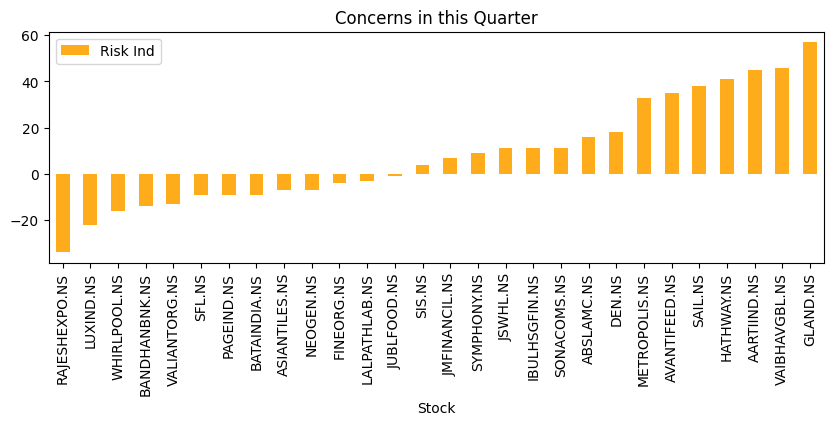

In [20]:
# concerns for this quarter
tmp_df = df_portfolio_features[(df_portfolio_features['LatestQtr'] == 1) & (df_portfolio_features['StarStock'] == 0)].sort_values(by = 'Risk Ind', ascending=True)
print('qualified stocks: '+str(tmp_df.shape[0]))
tmp_df.plot.bar(y='Risk Ind', x = 'Stock',  figsize=(10, 3), color='#FFAC1C', title='Concerns in this Quarter')

In [21]:
def plot_features_top_bottom(df_portfolio_features, column):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  tmp_df = df_portfolio_features.sort_values(by = column, ascending=False).head(5)
  tmp_df.plot.bar(y=column, x = 'Stock',  figsize=(10, 3), color='#4CBB17', title='Top 5 in ' + column, ax=ax1)
  tmp_df = df_portfolio_features.sort_values(by = column, ascending=True).head(5)
  tmp_df.plot.bar(y=column, x = 'Stock', figsize=(10, 3), color='#FFAC1C', title='Bottom 5 in ' + column, ax=ax2)

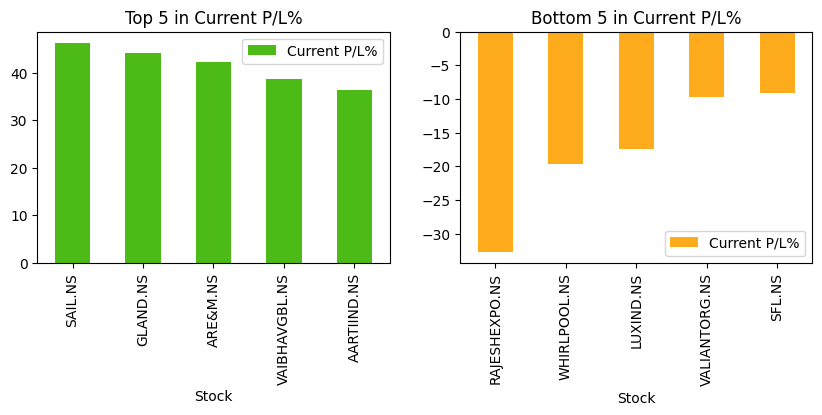

In [22]:
col = 'Current P/L%'
plot_features_top_bottom(df_portfolio_features, col)

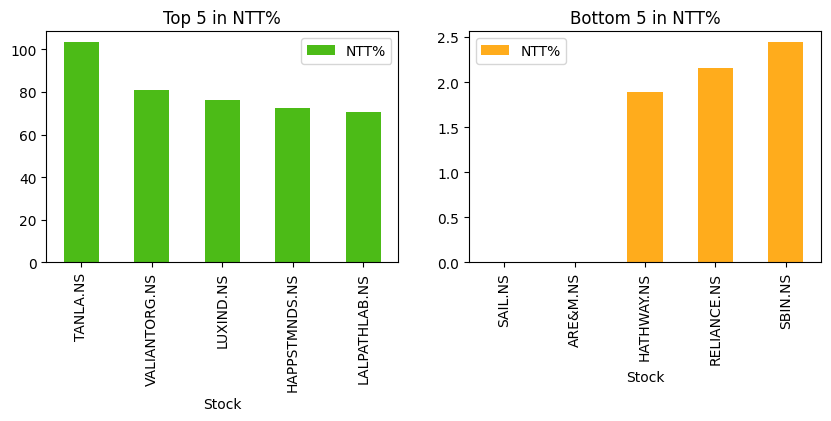

In [23]:
col = 'NTT%'
plot_features_top_bottom(df_portfolio_features, col)

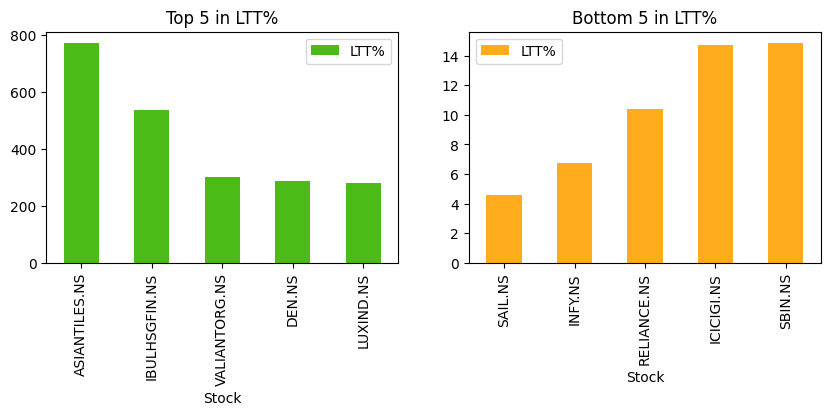

In [24]:
col = 'LTT%'
plot_features_top_bottom(df_portfolio_features, col)

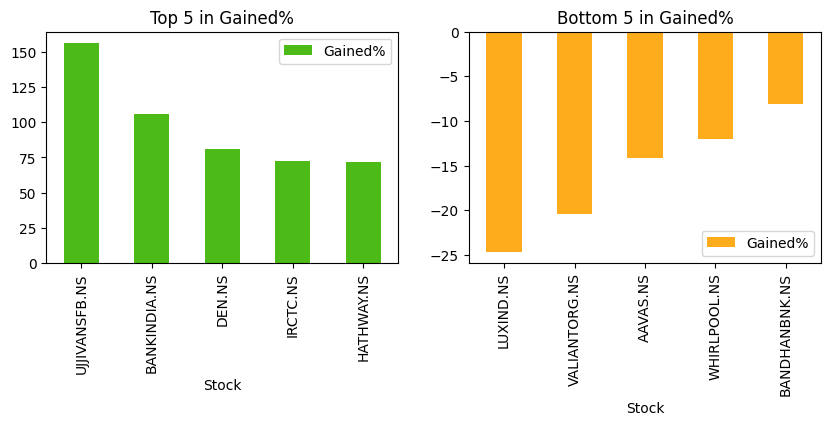

In [25]:
col = 'Gained%'
plot_features_top_bottom(df_portfolio_features, col)

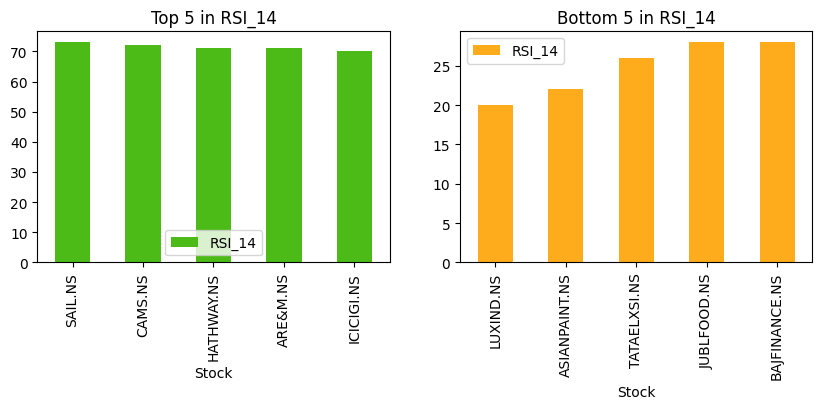

In [26]:
col = 'RSI_14'
plot_features_top_bottom(df_portfolio_features, col)

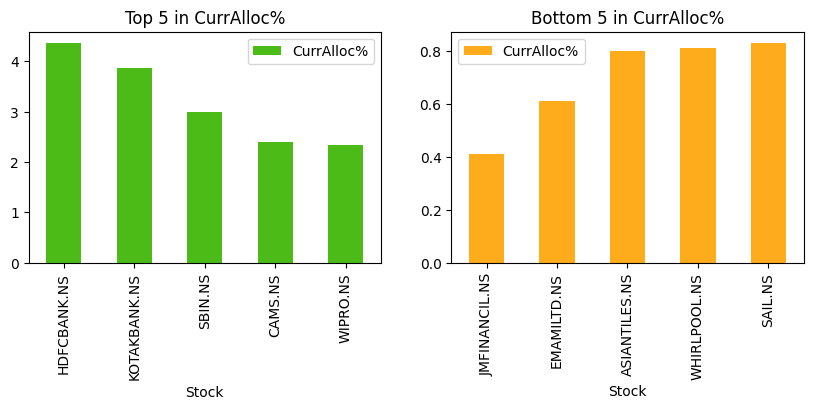

In [27]:
col = 'CurrAlloc%'
plot_features_top_bottom(df_portfolio_features, col)

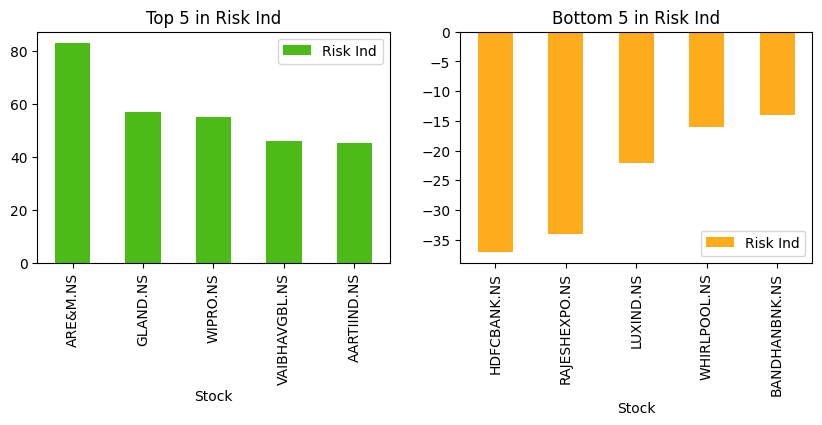

In [28]:
col = 'Risk Ind'
plot_features_top_bottom(df_portfolio_features, col)

In [29]:
def plot_feature_weights(df_portfolio_features, column):
  tmp_df = df_portfolio_features.groupby(column)['CurrAlloc%'].agg(['sum'])
  tmp_df = tmp_df.rename({'sum': 'CurrAlloc%'}, axis='columns')
  tmp_df = tmp_df.sort_values(by = 'CurrAlloc%', ascending=False)
  tmp_df.plot.pie(y='CurrAlloc%', autopct='%1.0f%%', figsize=(5, 5), legend=False, title='CurrAlloc% in ' + column)

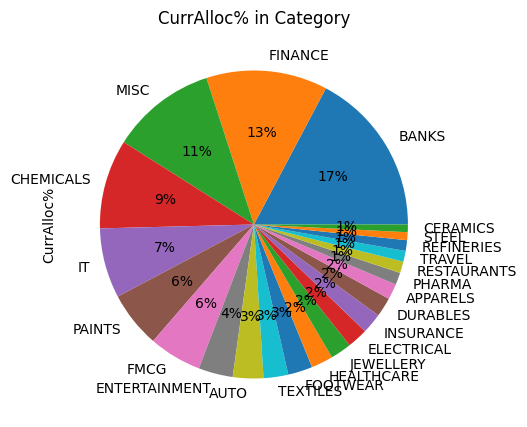

In [30]:
col = 'Category'
plot_feature_weights(df_portfolio_features, col)

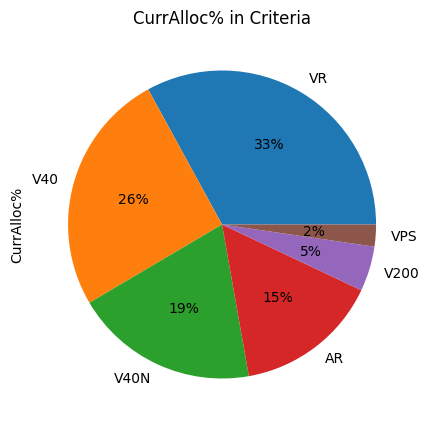

In [31]:
col = 'Criteria'
plot_feature_weights(df_portfolio_features, col)

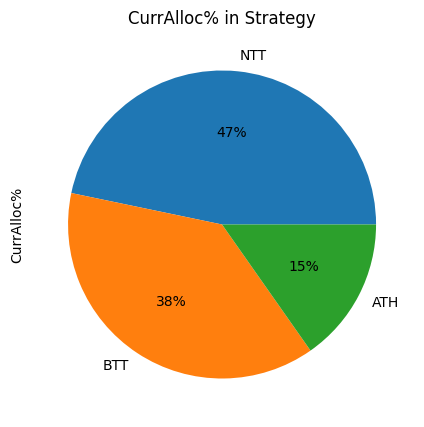

In [32]:
col = 'Strategy'
plot_feature_weights(df_portfolio_features, col)

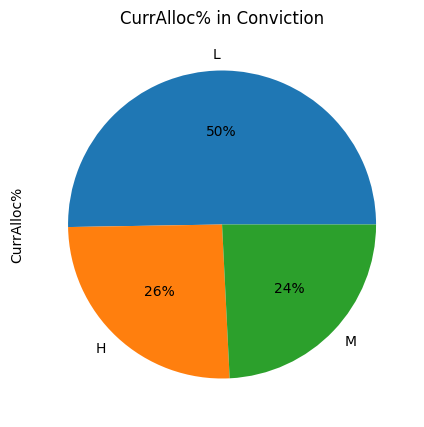

In [33]:
col = 'Conviction'
plot_feature_weights(df_portfolio_features, col)

In [34]:
# v40 and v40n
df_tmp = df_portfolio_features[df_portfolio_features['Criteria'].isin(['V40','V40N'])]
data_table.DataTable(df_tmp, include_index=False)

,Stock,Close,Avg_Cost,NTT,Dev%_200,Dev%_PE,RSI_14,Shares,Current,Current P/L,...,Gained%,CurrAlloc%,RRR Ind,Risk Ind,Criteria,Strategy,LatestQtr,StarStock,Conviction,Category
37,INFY.NS,1709.00,1403.85,1824.76,22.25,14.96,69.0,49.0,83741.0,14952.0,...,45.33,0.94,3.21,20.0,V40,ATH,1,1,H,IT
56,RELIANCE.NS,2853.65,2315.62,2915.40,14.74,-5.15,62.0,35.0,99878.0,18831.0,...,30.10,1.12,2.24,26.0,V40,BTT,1,1,H,REFINERIES
33,ICICIGI.NS,1556.10,1213.28,1607.10,17.53,-9.74,70.0,56.0,87142.0,19198.0,...,48.07,0.98,1.92,28.0,V40,BTT,1,1,H,INSURANCE
14,BAYERCROP.NS,5801.00,4346.57,6067.40,19.49,-12.83,51.0,16.0,92816.0,23271.0,...,49.92,1.04,1.58,35.0,V40N,BTT,1,1,M,CHEMICALS
44,KOTAKBANK.NS,1794.00,1792.90,2207.80,-1.97,-37.99,44.0,192.0,344448.0,211.0,...,8.93,3.86,0.00,0.0,V40,BTT,1,1,H,BANKS
31,HONAUT.NS,38499.95,35720.72,44000.00,-0.99,-2.68,63.0,3.0,115500.0,8338.0,...,11.88,1.29,0.29,10.0,V40N,NTT,0,0,M,ELECTRICAL
43,KANSAINER.NS,336.25,330.73,436.31,7.43,-24.51,49.0,362.0,121722.0,1998.0,...,35.86,1.36,0.06,2.0,V40N,ATH,1,1,M,PAINTS
8,BAJAJFINSV.NS,1610.40,1473.47,1904.97,3.50,-16.71,45.0,78.0,125611.0,10680.0,...,31.80,1.41,0.30,13.0,V40,BTT,1,1,H,FINANCE
20,DABUR.NS,534.35,523.35,638.90,-2.13,-1.83,45.0,175.0,93511.0,1925.0,...,6.86,1.05,0.06,2.0,V40,BTT,1,1,H,FMCG
53,PIDILITIND.NS,2605.70,2482.94,2889.66,2.26,-18.29,48.0,58.0,151131.0,7120.0,...,15.37,1.69,0.14,8.0,V40,BTT,1,1,H,CHEMICALS


In [35]:
# v40
df_tmp = df_portfolio_features[df_portfolio_features['Criteria'].isin(['V40'])]
data_table.DataTable(df_tmp, include_index=False)

,Stock,Close,Avg_Cost,NTT,Dev%_200,Dev%_PE,RSI_14,Shares,Current,Current P/L,...,Gained%,CurrAlloc%,RRR Ind,Risk Ind,Criteria,Strategy,LatestQtr,StarStock,Conviction,Category
37,INFY.NS,1709.00,1403.85,1824.76,22.25,14.96,69.0,49.0,83741.0,14952.0,...,45.33,0.94,3.21,20.0,V40,ATH,1,1,H,IT
56,RELIANCE.NS,2853.65,2315.62,2915.40,14.74,-5.15,62.0,35.0,99878.0,18831.0,...,30.10,1.12,2.24,26.0,V40,BTT,1,1,H,REFINERIES
33,ICICIGI.NS,1556.10,1213.28,1607.10,17.53,-9.74,70.0,56.0,87142.0,19198.0,...,48.07,0.98,1.92,28.0,V40,BTT,1,1,H,INSURANCE
44,KOTAKBANK.NS,1794.00,1792.90,2207.80,-1.97,-37.99,44.0,192.0,344448.0,211.0,...,8.93,3.86,0.00,0.0,V40,BTT,1,1,H,BANKS
8,BAJAJFINSV.NS,1610.40,1473.47,1904.97,3.50,-16.71,45.0,78.0,125611.0,10680.0,...,31.80,1.41,0.30,13.0,V40,BTT,1,1,H,FINANCE
20,DABUR.NS,534.35,523.35,638.90,-2.13,-1.83,45.0,175.0,93511.0,1925.0,...,6.86,1.05,0.06,2.0,V40,BTT,1,1,H,FMCG
53,PIDILITIND.NS,2605.70,2482.94,2889.66,2.26,-18.29,48.0,58.0,151131.0,7120.0,...,15.37,1.69,0.14,8.0,V40,BTT,1,1,H,CHEMICALS
48,MARICO.NS,527.15,530.08,584.95,-2.02,-8.82,48.0,200.0,105430.0,-586.0,...,13.24,1.18,-0.01,-1.0,V40,BTT,1,1,H,FMCG
9,BAJFINANCE.NS,6548.00,7148.10,8168.55,-9.40,-38.75,28.0,23.0,150604.0,-13802.0,...,19.33,1.69,-0.21,-14.0,V40,BTT,1,1,H,FINANCE
29,HDFCBANK.NS,1436.20,1569.25,1728.20,-10.18,-31.03,31.0,272.0,390646.0,-36190.0,...,0.62,4.37,-0.20,-37.0,V40,BTT,1,1,H,BANKS


In [36]:
# stocks to extend in Mom's account

df_data = df_portfolio_features[~df_portfolio_features["Stock"].isin(sv_pf['Stock'].values)]
data_table.DataTable(df_data, include_index=False)


,Stock,Close,Avg_Cost,NTT,Dev%_200,Dev%_PE,RSI_14,Shares,Current,Current P/L,...,Gained%,CurrAlloc%,RRR Ind,Risk Ind,Criteria,Strategy,LatestQtr,StarStock,Conviction,Category
37,INFY.NS,1709.00,1403.85,1824.76,22.25,14.96,69.0,49.0,83741.0,14952.0,...,45.33,0.94,3.21,20.0,V40,ATH,1,1,H,IT
33,ICICIGI.NS,1556.10,1213.28,1607.10,17.53,-9.74,70.0,56.0,87142.0,19198.0,...,48.07,0.98,1.92,28.0,V40,BTT,1,1,H,INSURANCE
14,BAYERCROP.NS,5801.00,4346.57,6067.40,19.49,-12.83,51.0,16.0,92816.0,23271.0,...,49.92,1.04,1.58,35.0,V40N,BTT,1,1,M,CHEMICALS
41,JSWHL.NS,6075.15,5569.56,6297.10,28.90,27.95,70.0,18.0,109353.0,9101.0,...,64.49,1.22,0.39,11.0,VPS,BTT,1,0,L,FINANCE
31,HONAUT.NS,38499.95,35720.72,44000.00,-0.99,-2.68,63.0,3.0,115500.0,8338.0,...,11.88,1.29,0.29,10.0,V40N,NTT,0,0,M,ELECTRICAL
63,SONACOMS.NS,630.05,578.05,800.00,12.91,-12.38,65.0,175.0,110259.0,9100.0,...,56.72,1.23,0.31,11.0,AR,NTT,1,0,M,AUTO
46,LTIM.NS,5421.10,5051.49,7385.38,3.95,31.58,38.0,16.0,86738.0,5914.0,...,32.08,0.97,0.20,7.0,V200,ATH,1,1,L,IT
51,NEOGEN.NS,1395.00,1489.90,1901.29,-11.71,18.29,38.0,68.0,94860.0,-6453.0,...,19.24,1.06,-0.18,-7.0,AR,ATH,1,0,L,CHEMICALS
62,SIS.NS,498.85,477.00,683.49,14.15,18.84,58.0,170.0,84804.0,3714.0,...,55.57,0.95,0.12,4.0,V40N,ATH,1,0,M,MISC
48,MARICO.NS,527.15,530.08,584.95,-2.02,-8.82,48.0,200.0,105430.0,-586.0,...,13.24,1.18,-0.01,-1.0,V40,BTT,1,1,H,FMCG


In [37]:
# stocks to extend in my account

df_data = df_portfolio_features[~df_portfolio_features["Stock"].isin(ar_pf['Stock'].values)]
data_table.DataTable(df_data, include_index=False)


,Stock,Close,Avg_Cost,NTT,Dev%_200,Dev%_PE,RSI_14,Shares,Current,Current P/L,...,Gained%,CurrAlloc%,RRR Ind,Risk Ind,Criteria,Strategy,LatestQtr,StarStock,Conviction,Category
56,RELIANCE.NS,2853.65,2315.62,2915.40,14.74,-5.15,62.0,35.0,99878.0,18831.0,...,30.10,1.12,2.24,26.0,V40,BTT,1,1,H,REFINERIES
39,JIOFIN.NS,277.20,234.69,289.10,18.97,NaN,66.0,573.0,158836.0,24359.0,...,34.17,1.78,1.17,32.0,VR,BTT,0,0,L,FINANCE
16,BRITANNIA.NS,5045.50,4515.41,5361.30,5.75,-0.55,45.0,17.0,85774.0,9012.0,...,22.19,0.96,0.53,11.0,AR,BTT,1,1,L,FMCG
43,KANSAINER.NS,336.25,330.73,436.31,7.43,-24.51,49.0,362.0,121722.0,1998.0,...,35.86,1.36,0.06,2.0,V40N,ATH,1,1,M,PAINTS
38,IRCTC.NS,958.05,864.50,1155.84,36.09,-8.53,57.0,105.0,100595.0,9822.0,...,72.18,1.13,0.33,12.0,AR,BTT,0,1,L,TRAVEL
20,DABUR.NS,534.35,523.35,638.90,-2.13,-1.83,45.0,175.0,93511.0,1925.0,...,6.86,1.05,0.06,2.0,V40,BTT,1,1,H,FMCG
49,MASFIN.NS,1023.00,980.00,1201.76,23.25,2.62,68.0,100.0,102300.0,4300.0,...,50.10,1.15,0.12,5.0,AR,BTT,1,1,L,FINANCE
68,TATAELXSI.NS,7680.00,7332.28,10601.79,0.76,16.70,26.0,14.0,107520.0,4868.0,...,30.61,1.20,0.12,6.0,V40N,ATH,1,1,M,IT
30,HINDUNILVR.NS,2429.40,2507.89,2737.03,-4.50,-15.81,38.0,32.0,77741.0,-2511.0,...,2.54,0.87,-0.07,-3.0,V40,BTT,1,1,H,FMCG
40,JMFINANCIL.NS,107.25,91.25,130.00,30.79,56.25,54.0,338.0,36250.0,5408.0,...,50.53,0.41,0.31,7.0,VR,NTT,1,0,L,FINANCE


In [38]:
cols = ['Stock', 'NTT%', 'LTT%', 'CurrAlloc%', 'Strategy']
#cols = ['Stock',  'Dev%_200', 'Dev%_PE', 'RSI_14', 'Today P/L%', 'Current P/L%', 'NTT%', 'LTT%', 'Gained%', 'CurrAlloc%', 'RRR Ind',  'Risk Ind', 'Criteria', 'Strategy','LatestQtr', 'StarStock', 'Conviction', 'Category']
df_portfolio_features[cols] #.replace({'V40': 'A35', 'V40N': 'A75', 'V200': 'A99', 'VR': 'AR'})

,Stock,NTT%,LTT%,CurrAlloc%,Strategy
58,SAIL.NS,0.00,4.61,0.83,BTT
37,INFY.NS,6.77,6.77,0.94,ATH
56,RELIANCE.NS,2.16,10.38,1.12,BTT
33,ICICIGI.NS,3.28,14.71,0.98,BTT
60,SBIN.NS,2.44,14.88,3.00,BTT
...,...,...,...,...,...
47,LUXIND.NS,76.25,278.86,1.27,NTT
21,DEN.NS,21.75,288.56,1.10,NTT
73,VALIANTORG.NS,81.05,299.84,1.35,NTT
32,IBULHSGFIN.NS,41.94,536.19,1.25,NTT
